In [1]:
import os
import sys
file_dir = os.path.dirname(os.path.dirname(os.path.abspath("/home/rodr/code/mobility-baselines/STG-NCDE-main")))
print(file_dir)
sys.path.append(file_dir)

import torch
import numpy as np
import torch.nn as nn
import argparse
import configparser
import time
from matplotlib import pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor

from model.BasicTrainer_cde import Trainer
from lib.TrainInits import init_seed
from lib.dataloader import *
from lib.TrainInits import print_model_parameters
import os
from os.path import join
from model.Make_model import make_model
from torch.utils.tensorboard import SummaryWriter
#*************************************************************************#
Mode = 'train'
DEBUG = 'False'
DATASET = 'PEMSD4'      #PEMSD4 or PEMSD8
MODEL = 'GCDE'

#get configuration
config_file = 'model/{}_{}.conf'.format(DATASET, MODEL)
#print('Read configuration file: %s' % (config_file))
config = configparser.ConfigParser()
config.read(config_file)

from lib.metrics import MAE_torch
def masked_mae_loss(scaler, mask_value):
    def loss(preds, labels):
        if scaler:
            preds = scaler.inverse_transform(preds)
            labels = scaler.inverse_transform(labels)
        mae = MAE_torch(pred=preds, true=labels, mask_value=mask_value)
        return mae
    return loss

# python Run_cde.py --dataset='PEMSD4' --model='GCDE' --model_type='type1' --embed_dim=10 --hid_dim=64 --hid_hid_dim=64 --num_layers=2 --lr_init=0.001 --weight_decay=1e-3 --epochs=200 --tensorboard --comment="" --device=0

#parser
args = argparse.ArgumentParser(description='arguments')
args.add_argument('--dataset', default=DATASET, type=str)
args.add_argument('--mode', default=Mode, type=str)
args.add_argument('--device', default=0, type=int, help='indices of GPUs')
args.add_argument('--debug', default=DEBUG, type=eval)
args.add_argument('--model', default=MODEL, type=str)
args.add_argument('--cuda', default=True, type=bool)
args.add_argument('--comment', default='', type=str)
args.add_argument("-f", type=str, default="")


#data
args.add_argument('--val_ratio', default=config['data']['val_ratio'], type=float)
args.add_argument('--test_ratio', default=config['data']['test_ratio'], type=float)
args.add_argument('--lag', default=config['data']['lag'], type=int)
args.add_argument('--horizon', default=config['data']['horizon'], type=int)
args.add_argument('--num_nodes', default=config['data']['num_nodes'], type=int)
args.add_argument('--tod', default=config['data']['tod'], type=eval)
args.add_argument('--normalizer', default=config['data']['normalizer'], type=str)
args.add_argument('--column_wise', default=config['data']['column_wise'], type=eval)
args.add_argument('--default_graph', default=config['data']['default_graph'], type=eval)
#model
args.add_argument('--model_type', default=config['model']['type'], type=str)
args.add_argument('--g_type', default=config['model']['g_type'], type=str)
args.add_argument('--input_dim', default=config['model']['input_dim'], type=int)
args.add_argument('--output_dim', default=config['model']['output_dim'], type=int)
args.add_argument('--embed_dim', default=config['model']['embed_dim'], type=int)
args.add_argument('--hid_dim', default=config['model']['hid_dim'], type=int)
args.add_argument('--hid_hid_dim', default=config['model']['hid_hid_dim'], type=int)
args.add_argument('--num_layers', default=config['model']['num_layers'], type=int)
args.add_argument('--cheb_k', default=config['model']['cheb_order'], type=int)
args.add_argument('--solver', default='rk4', type=str)

#train
args.add_argument('--loss_func', default=config['train']['loss_func'], type=str)
args.add_argument('--seed', default=config['train']['seed'], type=int)
args.add_argument('--batch_size', default=config['train']['batch_size'], type=int)
args.add_argument('--epochs', default=config['train']['epochs'], type=int)
args.add_argument('--lr_init', default=config['train']['lr_init'], type=float)
args.add_argument('--weight_decay', default=config['train']['weight_decay'], type=eval)
args.add_argument('--lr_decay', default=config['train']['lr_decay'], type=eval)
args.add_argument('--lr_decay_rate', default=config['train']['lr_decay_rate'], type=float)
args.add_argument('--lr_decay_step', default=config['train']['lr_decay_step'], type=str)
args.add_argument('--early_stop', default=config['train']['early_stop'], type=eval)
args.add_argument('--early_stop_patience', default=config['train']['early_stop_patience'], type=int)
args.add_argument('--grad_norm', default=config['train']['grad_norm'], type=eval)
args.add_argument('--max_grad_norm', default=config['train']['max_grad_norm'], type=int)
args.add_argument('--teacher_forcing', default=False, type=bool)
#args.add_argument('--tf_decay_steps', default=2000, type=int, help='teacher forcing decay steps')
args.add_argument('--real_value', default=config['train']['real_value'], type=eval, help = 'use real value for loss calculation')

args.add_argument('--missing_test', default=False, type=bool)
args.add_argument('--missing_rate', default=0.1, type=float)

#test
args.add_argument('--mae_thresh', default=config['test']['mae_thresh'], type=eval)
args.add_argument('--mape_thresh', default=config['test']['mape_thresh'], type=float)
args.add_argument('--model_path', default='', type=str)
#log
args.add_argument('--log_dir', default='../runs', type=str)
args.add_argument('--log_step', default=config['log']['log_step'], type=int)
args.add_argument('--plot', default=config['log']['plot'], type=eval)
args.add_argument('--tensorboard',action='store_true',help='tensorboard')

args = args.parse_args()
init_seed(args.seed)

GPU_NUM = args.device
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print(args)

#load dataset
#train_loader, val_loader, test_loader, scaler, times = get_dataloader_cde(args,
#                                                               normalizer=args.normalizer,
#                                                               tod=args.tod, dow=False,
#                                                               weather=False, single=False)

#load raw st dataset
data = load_st_dataset(args.dataset)        # B, N, D
print(data.shape) 
# PEMSD4 timeframe: 01/2018 - 02/2018

/home/rodr/code
Namespace(batch_size=64, cheb_k=2, column_wise=False, comment='', cuda=True, dataset='PEMSD4', debug=False, default_graph=True, device=0, early_stop=True, early_stop_patience=15, embed_dim=10, epochs=100, f='/home/rodr/.local/share/jupyter/runtime/kernel-8ff59059-8e28-48ee-83ec-fce23fc5d639.json', g_type='agc', grad_norm=False, hid_dim=128, hid_hid_dim=128, horizon=12, input_dim=2, lag=12, log_dir='../runs', log_step=20, loss_func='mae', lr_decay=False, lr_decay_rate=0.3, lr_decay_step='5,20,40,70', lr_init=0.001, mae_thresh=None, mape_thresh=0.0, max_grad_norm=5, missing_rate=0.1, missing_test=False, mode='train', model='GCDE', model_path='', model_type='type1', normalizer='std', num_layers=3, num_nodes=307, output_dim=1, plot=False, real_value=True, seed=10, solver='rk4', teacher_forcing=False, tensorboard=False, test_ratio=0.2, tod=False, val_ratio=0.2, weight_decay=0.001)
Load PEMSD4 Dataset shaped:  (16992, 307, 1) 919.0 0.0 211.7007794815878 180.0
(16992, 307, 1)


In [2]:
from workalendar.usa.california import CaliforniaSanFrancisco
holidays = [CaliforniaSanFrancisco().holidays(y) for y in [2018]][0]
holidays

[(datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 1, 15), 'Birthday of Martin Luther King, Jr.'),
 (datetime.date(2018, 2, 19), "Washington's Birthday"),
 (datetime.date(2018, 5, 28), 'Memorial Day'),
 (datetime.date(2018, 7, 4), 'Independence Day'),
 (datetime.date(2018, 9, 3), 'Labor Day'),
 (datetime.date(2018, 10, 8), 'Columbus Day'),
 (datetime.date(2018, 11, 11), 'Veterans Day'),
 (datetime.date(2018, 11, 12), 'Veterans Day (Observed)'),
 (datetime.date(2018, 11, 22), 'Thanksgiving Day'),
 (datetime.date(2018, 11, 23), 'Thanksgiving Friday'),
 (datetime.date(2018, 12, 25), 'Christmas Day')]

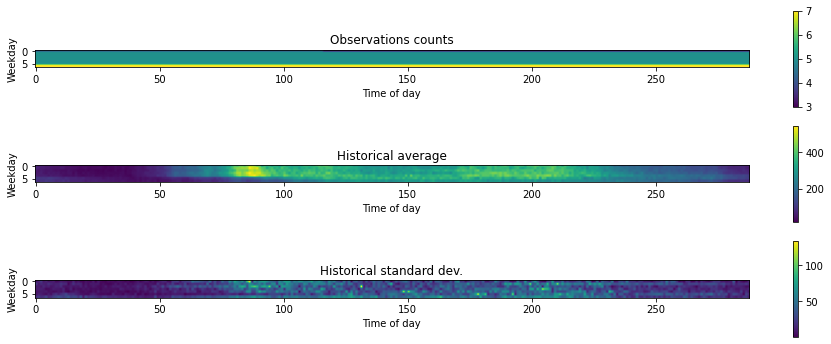

In [3]:
sys.path.append(os.path.abspath("/home/rodr/code/mobility-baselines"))
from mobility_detrender import MobilityDetrender
from evaluation import evaluation

detrender = MobilityDetrender(day_duration=12*24, week_duration=7)
trainset_len = len(data)-int(len(data)*(args.test_ratio+args.val_ratio)) # use only trainset for fitting HA
detrender.fit(data[:trainset_len,:,0], start_date=datetime.date(2018,1,1), holidays=[0,14,49])
detrender.visualize(0)

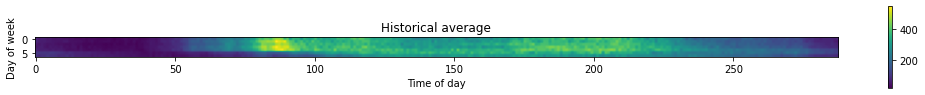

In [4]:
loc = 0
plt.figure(figsize=(18,1.5))
img = plt.imshow(detrender.historical_avg[loc,:,:])
plt.title("Historical average")
plt.xlabel("Time of day")
plt.ylabel("Day of week")
plt.colorbar(img)
plt.savefig("stg-ncde-HA.pdf")
plt.show()

In [5]:
detrended_data = detrender.transform(data[:,:,0], start_date=datetime.date(2018,1,1), holidays=[0,14,49], mode='avg')
evl_train = evaluation(data[:,:,0], detrender.ha_trend)
print('Residuals of Historical Average (on all data) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 
detrended_data.shape

Residuals of Historical Average (on all data) -> MAPE: 0.159; MAE:  22.626; RMSE: 37.999


(16992, 307)

In [6]:
#split dataset by days or by ratio
data_train, data_val, data_test = split_data_by_ratio(data, args.val_ratio, args.test_ratio)
ha_train, ha_val, ha_test = split_data_by_ratio(detrender.ha_trend[:,:,np.newaxis], args.val_ratio, args.test_ratio)

#add time window
single=False
x_tra, y_tra = Add_Window_Horizon(data_train, args.lag, args.horizon, single)
x_val, y_val = Add_Window_Horizon(data_val, args.lag, args.horizon, single)
x_test, y_test = Add_Window_Horizon(data_test, args.lag, args.horizon, single)
print('Train: ', x_tra.shape, y_tra.shape)
print('Val: ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)
x_tra_ha, y_tra_ha = Add_Window_Horizon(ha_train, args.lag, args.horizon, single)
x_val_ha, y_val_ha = Add_Window_Horizon(ha_val, args.lag, args.horizon, single)
x_test_ha, y_test_ha = Add_Window_Horizon(ha_test, args.lag, args.horizon, single)
print('Train HA: ', x_tra_ha.shape, y_tra_ha.shape)
print('Val HA: ', x_val_ha.shape, y_val_ha.shape)
print('Test HA: ', x_test_ha.shape, y_test_ha.shape)

Train:  (10173, 12, 307, 1) (10173, 12, 307, 1)
Val:  (3375, 12, 307, 1) (3375, 12, 307, 1)
Test:  (3375, 12, 307, 1) (3375, 12, 307, 1)
Train HA:  (10173, 12, 307, 1) (10173, 12, 307, 1)
Val HA:  (3375, 12, 307, 1) (3375, 12, 307, 1)
Test HA:  (3375, 12, 307, 1) (3375, 12, 307, 1)


In [8]:
evl_val = evaluation(y_val[:,0,:,:], y_val_ha[:,0,:,:])
print('Validation set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_val)) 

evl_test = evaluation(y_test[:,0,:,:], y_test_ha[:,0,:,:])
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

Validation set -> MAPE: 0.153; MAE:  24.431; RMSE: 40.938
Test set -> MAPE: 0.17066; MAE:  26.259; RMSE: 42.861


In [9]:
all_preds = []
all_trues = []
for loc in range(data.shape[1]):
    if not loc % 50:
        print(loc)
    
    loc_preds = []
    loc_trues = []
    for steps_ahead in range(12):
        # prepare input data
        x = x_tra[:, :, loc, 0] - x_tra_ha[:, :, loc, 0] # detrend input data for training
        y = y_tra[:, steps_ahead, loc, 0] - y_tra_ha[:, steps_ahead, loc, 0] # detrend targets for training
        
        # fit ML models
        reg = LinearRegression()
        reg.fit(x, y)
        
        # predict on test set
        trues = y_test[:, steps_ahead, loc, 0] # targets for test set (i.e., actual observations w/o detrending)
        preds = reg.predict(x_test[:, :, loc, 0] - x_test_ha[:, :, loc, 0]) # make predictions on detrended inputs
        preds = preds + y_test_ha[:, steps_ahead, loc, 0] # convert preds back to original scale (revert detrending)

        loc_preds.append(preds)
        loc_trues.append(trues)

    all_preds.append(loc_preds)
    all_trues.append(loc_trues)

all_preds = np.array(all_preds).transpose([2,0,1])
print(all_preds.shape)
all_trues = np.array(all_trues).transpose([2,0,1])
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.5f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

0
50
100
150
200
250
300
(3375, 307, 12)
(3375, 307, 12)
Test set -> MAPE: 0.13387; MAE:  20.032; RMSE: 32.729


In [21]:
# sanity check by having an empty model that predicts always zero - this is the same as predicting using HA only

all_preds = []
all_trues = []
for loc in range(data.shape[1]):
    if not loc % 50:
        print(loc)
    
    loc_preds = []
    loc_trues = []
    for steps_ahead in range(12):
        # prepare input data
        x = x_tra[:, :, loc, 0] - x_tra_ha[:, :, loc, 0] # detrend input data for training
        y = y_tra[:, steps_ahead, loc, 0] - y_tra_ha[:, steps_ahead, loc, 0] # detrend targets for training
        
        # no ML model
        
        # predict on test set
        trues = y_test[:, steps_ahead, loc, 0] # targets for test set (i.e., actual observations w/o detrending)
        preds = 0 # prediction is always zero
        preds = preds + y_test_ha[:, steps_ahead, loc, 0] # convert preds back to original scale (revert detrending)

        loc_preds.append(preds)
        loc_trues.append(trues)

    all_preds.append(loc_preds)
    all_trues.append(loc_trues)

all_preds = np.array(all_preds).transpose([2,0,1])
print(all_preds.shape)
all_trues = np.array(all_trues).transpose([2,0,1])
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

0
50
100
150
200
250
300
(3375, 307, 12)
(3375, 307, 12)
Test set -> MAPE: 0.171; MAE:  26.264; RMSE: 42.868
